In [1]:
import platform
import os
import sys
import pandas as pd
import numpy.random as rd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'Osaka'
plt.rcParams["patch.force_edgecolor"] = True

In [2]:
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.rinterface import R_VERSION_BUILD
#from rpy2.robjects.functions import SignatureTranslatedFunction

from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [3]:
print("env:", platform.system())
print("os.name:", os.name)
print("python ver:", platform.python_version())
print("python env:", sys.version)
print("rpy2 version:", rpy2.__version__)
print("R_VERSION_BUILD:", R_VERSION_BUILD)



env: Darwin
os.name: posix
python ver: 3.5.2
python env: 3.5.2 |Anaconda 4.3.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
rpy2 version: 2.8.2
R_VERSION_BUILD: ('3', '3.1', '', 70800)


# データ作成

In [125]:
rd.seed(71)

T = 500
v_sd = 20 # 観測誤差の標準偏差
i_sd = 10 # interceptの標準偏差
e_sd = [0.5, 0.8, 1.2, 1.0] # 回帰係数の変動の標準偏差
a0   = [10, 20, 15, 18]    # 回帰係数の初期値(ゲタ)

assert len(e_sd)==len(a0)

# 時変回帰係数２つ
e = np.zeros((len(e_sd), T))
a = np.zeros((len(a0), T))
for i, (sd, a0_) in enumerate(zip(e_sd, a0)):
    e[i] = np.random.normal(0, sd, size=T)
    a[i] = e[i].cumsum() + a0_
    print(i, sd, a0_)

    
# intercept
intercept = np.cumsum(np.random.normal(0, i_sd, size=T))

# 説明変数
x = rd.normal(10, 10, size=(len(e_sd), T))

# 被説明変数
v = np.random.normal(0, v_sd, size=T) # 観測誤差
y_noerror = intercept + np.diag(np.dot(a.T, x))  # 観測誤差がなかった時の　y
y = y_noerror + v

0 0.5 10
1 0.8 20
2 1.2 15
3 1.0 18


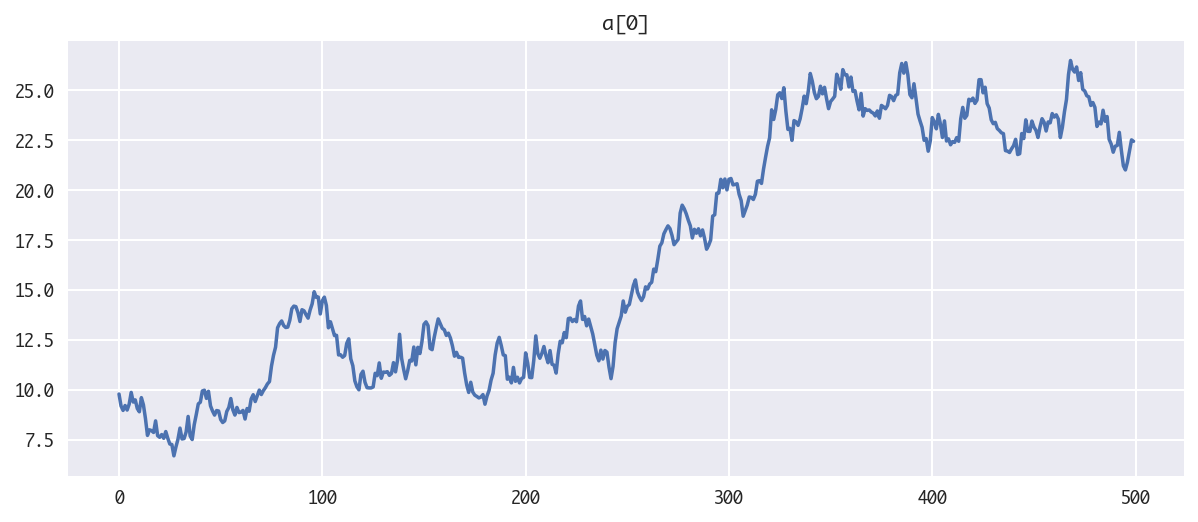

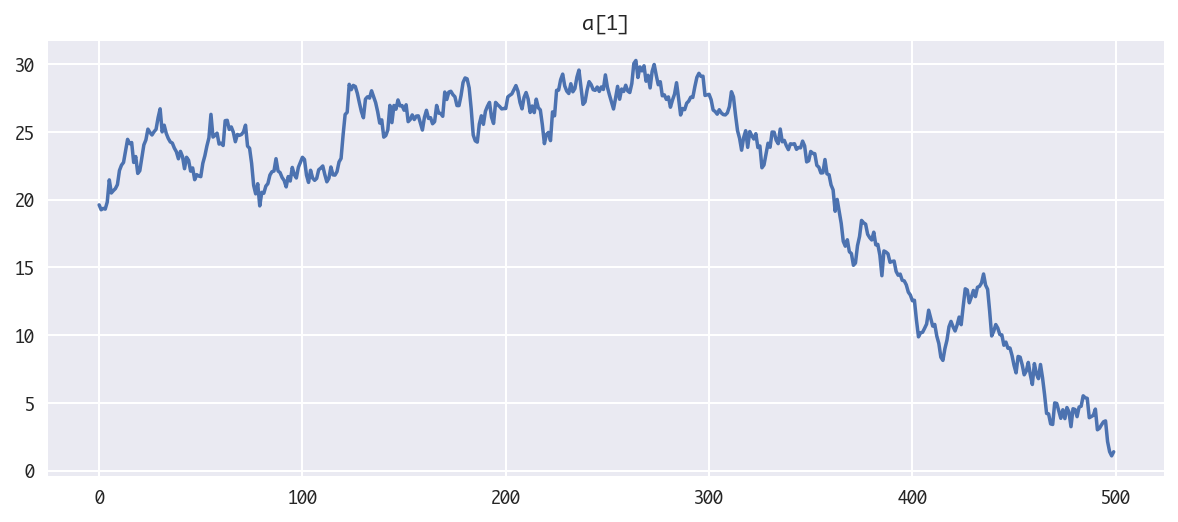

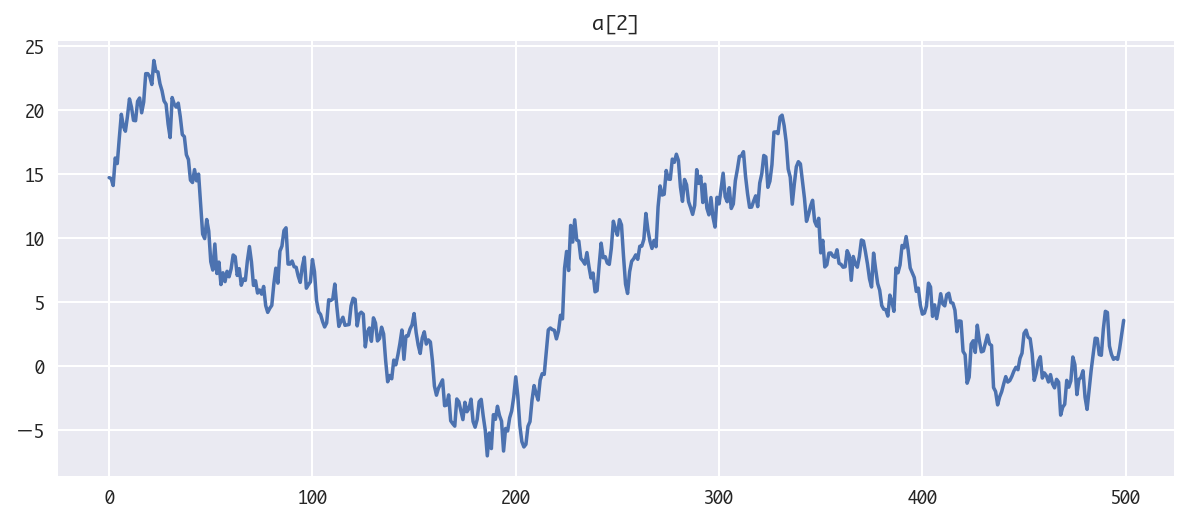

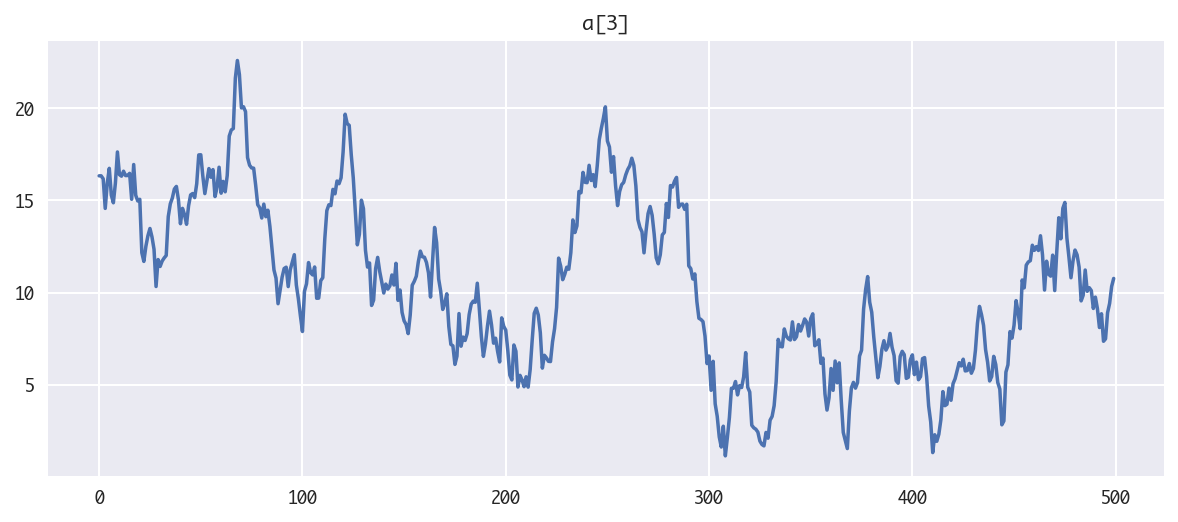

In [126]:
# 時変回帰係数のプロット
for i, val in enumerate(a):
    plt.figure(figsize=(10,4))
    plt.plot(val)
    plt.title("a[{}]".format(i))

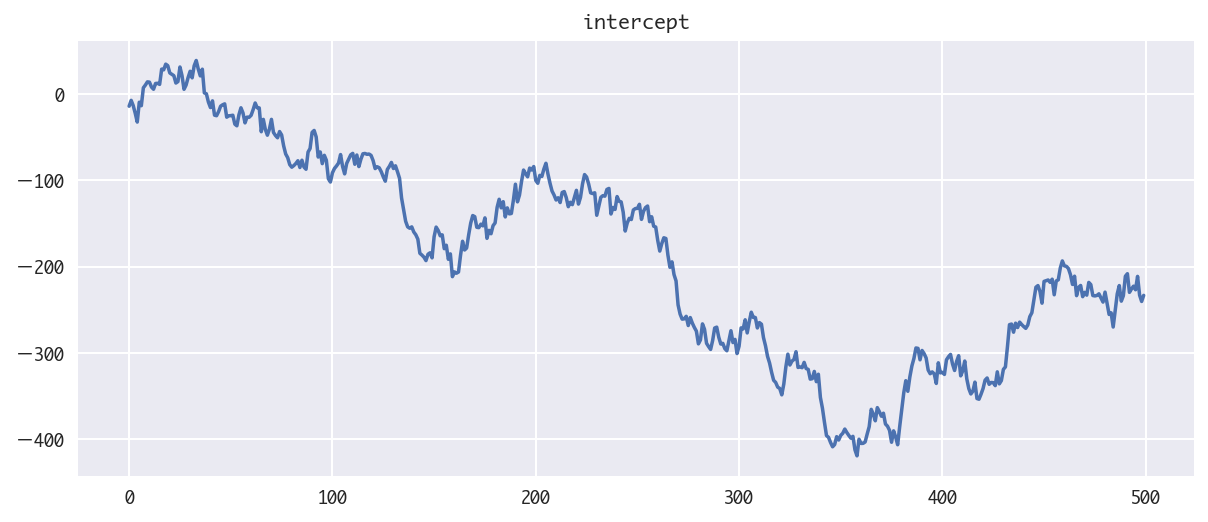

In [127]:
# interceptをプロット
plt.figure(figsize=(10,4))
plt.plot(intercept)
plt.title("intercept")

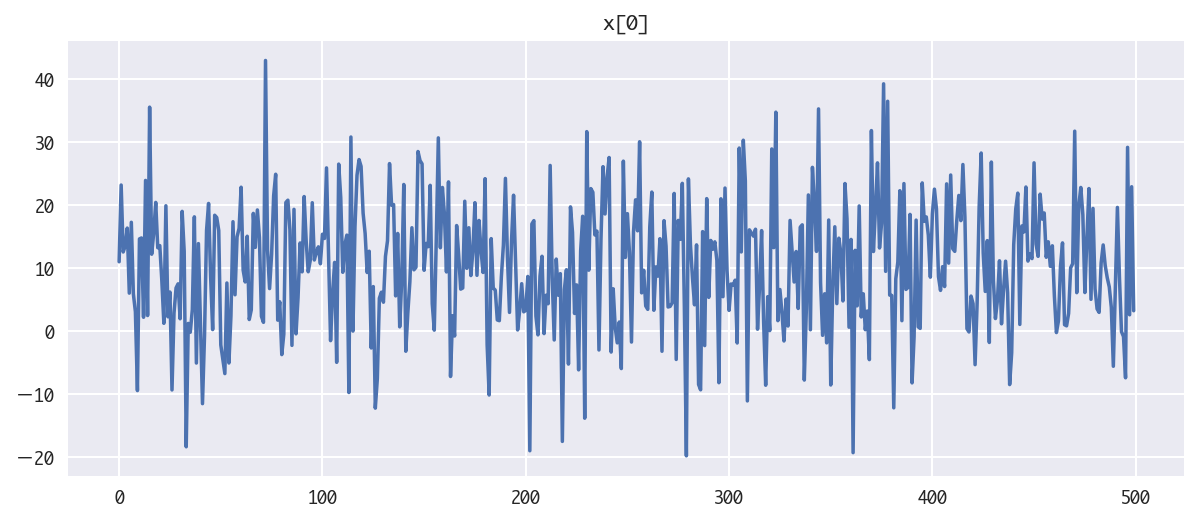

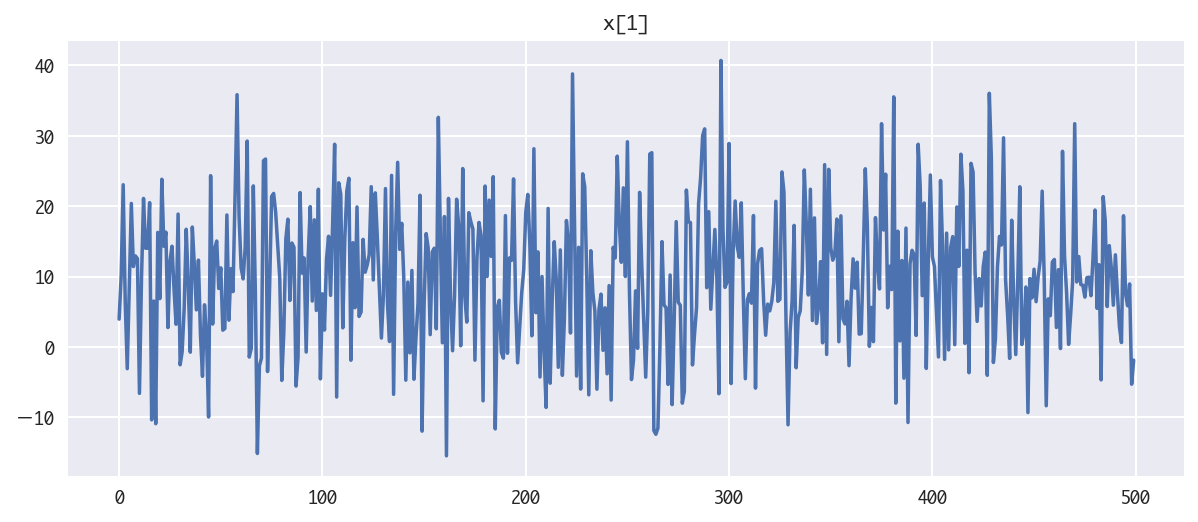

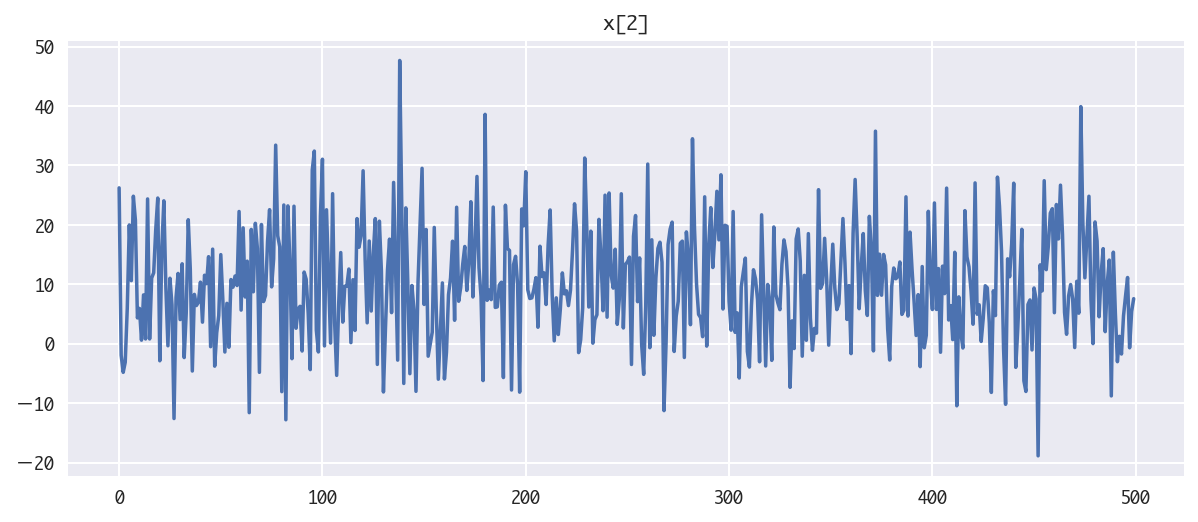

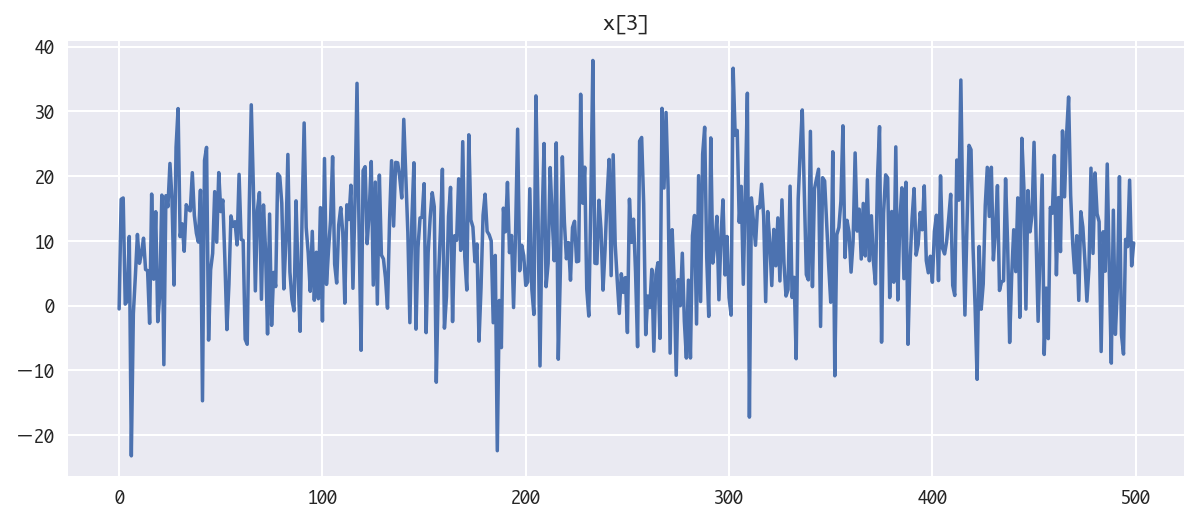

In [128]:
# 説明変数をプロット
for i, val in enumerate(x):
    plt.figure(figsize=(10,4))
    plt.plot(val)
    plt.title("x[{}]".format(i))


# plt.figure(figsize=(10,4))
# plt.plot(x1)
# plt.title("x1")

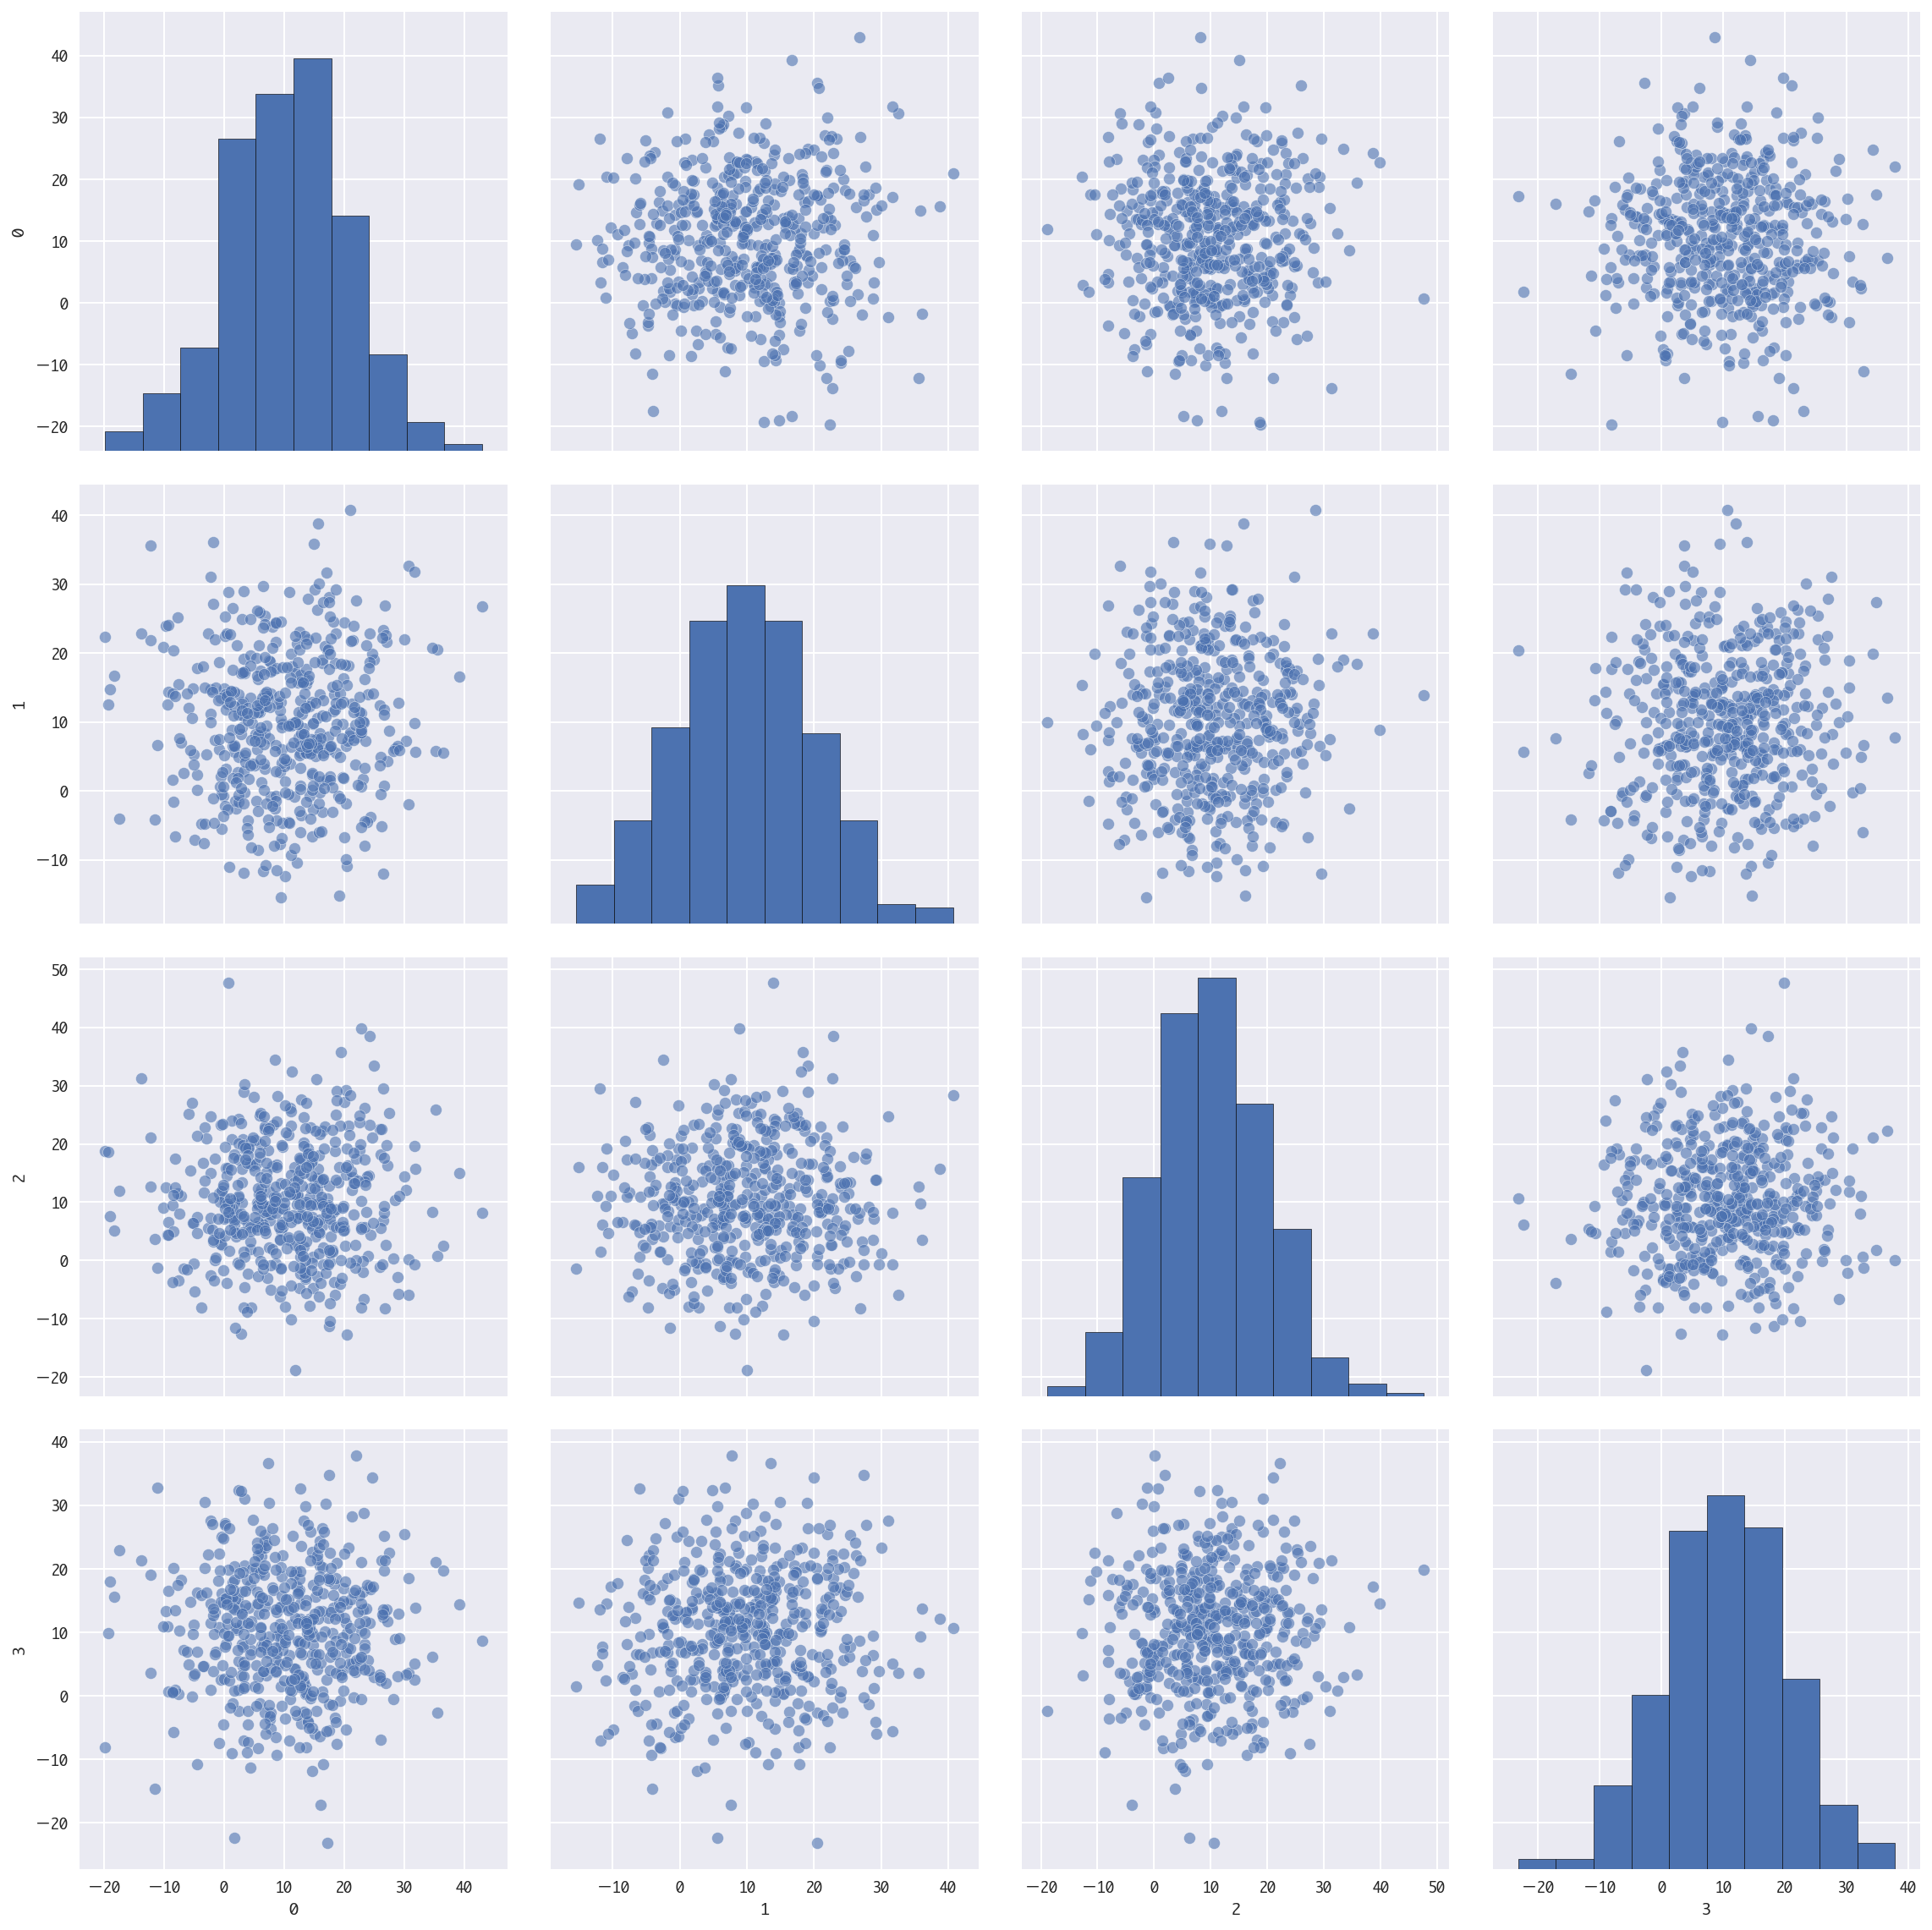

In [129]:
# 説明変数の散布図
sns.pairplot(pd.DataFrame(x).T, size=4, plot_kws={"alpha":.6})
#plt.figure(figsize=(6,6))
#plt.scatter(x1, x2, alpha=0.7)


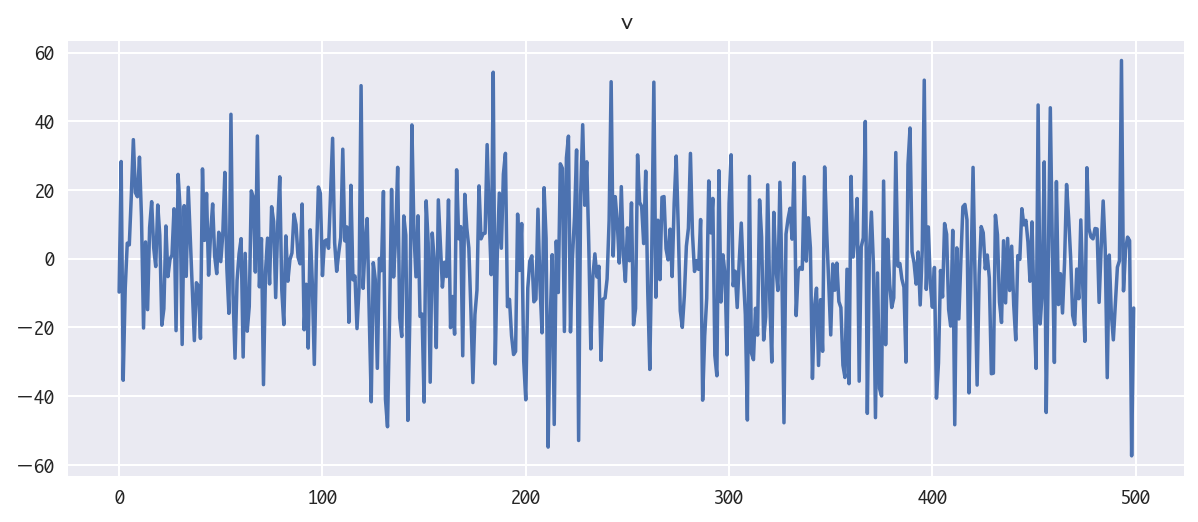

In [130]:
# 観測誤差のプロット
plt.figure(figsize=(10,4))
plt.plot(v)
plt.title("v")

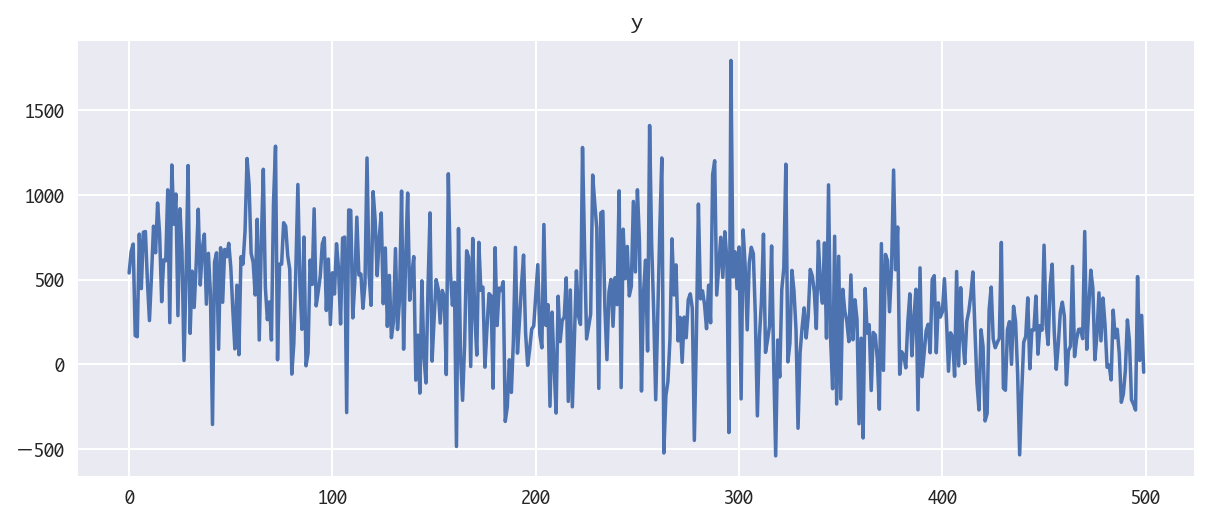

In [131]:
# 観測値をプロット
plt.figure(figsize=(10,4))
plt.plot(y)
plt.title("y")

In [132]:
x.shape

(4, 500)

In [133]:
x_dict = {"x{}".format(i): x[i] for i in range(x.shape[0])}

In [134]:
a_dict = {"a{}".format(i): a[i] for i in range(a.shape[0])}

In [135]:
param_dict = {"y":y, "intercept":intercept}
param_dict.update(x_dict)
param_dict.update(a_dict)


In [136]:
df = pd.DataFrame(param_dict)
df.head()

a0         a1         a2         a3  intercept         x0         x1  \
0  9.784698  19.610076  14.734182  16.323177 -14.238996  11.009824   3.963525   
1  9.187734  19.249373  14.663447  16.323307  -7.478812  23.175271  10.087015   
2  8.965585  19.348741  14.118959  16.162152 -13.464128  12.557703  23.051557   
3  9.210291  19.297976  16.266259  14.559052 -22.373165  13.528975   6.400909   
4  8.984512  19.822178  15.832055  15.919881 -32.622780  16.347069  -3.071735   

          x2         x3           y  
0  26.220284  -0.516801  539.421445  
1  -1.938599  16.417178  667.479908  
2  -4.824083  16.622322  710.312974  
3  -3.124907   0.229274  169.661597  
4   5.930644   0.709285  163.077934

In [137]:
df.to_csv("data.csv")

# DLM


In [138]:
def get_method(result, method_name):
    """Rの関数の戻り値で取得したオブジェクトの関数を取り出す
    result: Rの関数の戻り値で取得したオブジェクト
    method_name: 取り出したいメソッドの名称
    """
    for i in result.items():
        if i[0] == method_name:
            return i[1]
    assert False

In [139]:
def show_result(result):
    """Rの関数の戻り値で取得したオブジェクトの関数を取り出す
    result: Rの関数の戻り値で取得したオブジェクト
    method_name: 取り出したいメソッドの名称
    """
    for i in result.items():
        print(i[0], i[1], )

In [140]:
dlm = importr("dlm")

In [141]:
score_select = np.array(pd.Series(df.columns).str.contains("x")) # "score"を列名に含むかどうかの論理判定
df_x = df.ix[:,score_select]   # 論理配列を使って列選択
x_keys = list(df_x.keys())
x_keys.sort()
df_x = df_x.ix[:,x_keys]

In [142]:
df_x

x0         x1         x2         x3
0    11.009824   3.963525  26.220284  -0.516801
1    23.175271  10.087015  -1.938599  16.417178
2    12.557703  23.051557  -4.824083  16.622322
3    13.528975   6.400909  -3.124907   0.229274
4    16.347069  -3.071735   5.930644   0.709285
5     6.036904   8.569466  19.981331  10.670380
6    17.267122  20.399765  10.611444 -23.208125
7     5.936314  11.428210  24.813847  -1.233682
8     3.091148  12.936894  20.814573   4.654449
9    -9.418199  12.554317   4.334219  10.982328
10   14.634015  -6.578063   5.940651   6.528550
11   14.785468   9.688631   0.595334   8.044584
12    2.207439  21.106196   8.208602  10.406018
13   23.905026  14.035790   0.794834   5.576309
14    2.484074  14.043878  24.356109   5.391358
15   35.526209  20.513143   0.796542  -2.733123
16   12.207996 -10.346326  11.055387  17.219707
17   15.538651   6.532793  11.935826   4.075759
18   20.418648 -10.886179  19.156772  14.496022
19   13.228809  16.285145  24.506327  -2.486433
20   13.570903   6.875687  -2.875282   1.644587
21    8.027277  23.831175  16.080557  17.062567
22    1.248175  14.318417  24.041101  -9.130049
23   19.887309  16.326300   9.352695  16.970570
24    2.282760   2.766645  -0.351569  15.275287
25    6.204453  12.171658  11.008817  21.953971
26   -9.316492  14.316144   6.506688  16.455353
27    2.887071   8.241407 -12.593638   3.169990
28    6.860306   3.235870   7.785409  24.449353
29    7.511298  18.885464  11.818933  30.426603
..         ...        ...        ...        ...
470  31.716384  31.725563  -0.648689   5.066786
471   6.108697   9.240283  10.491307  10.789013
472  19.874647  12.857130   5.132682   0.803849
473  22.790160   8.876406  39.889965  14.497101
474  18.444793   8.779909  20.434526  12.131490
475   6.127902   7.086845  11.086986   6.957470
476  14.747411   9.854660  17.950022   0.693174
477  22.616001   9.919889  24.806088   5.842623
478   5.052475   7.291909   7.378320  21.221909
479  19.464865  12.622805   0.009464   8.060299
480   6.740356  19.457992  20.482795  20.481639
481   3.538317   5.497431  17.264556  14.194192
482   2.980842  11.696593   4.529557  12.955091
483  10.827080  -4.668101  11.797172  -7.093543
484  13.676841  21.362880  15.989046  11.400834
485  10.410321  17.987171   2.026066   5.312562
486   8.476644   5.753628  10.152514  21.862829
487   7.019314  14.403704  14.067609   5.504776
488   3.786752  11.261749  -8.786147  -8.888152
489  -5.560296   5.946128  15.396571  14.735680
490   6.824318  13.098402   5.090315  -4.442899
491  19.624477   7.646921  -3.028537   2.879237
492   8.581490   2.874663   1.237367  19.906305
493  -0.068547   0.636555  -1.735528  -4.512577
494  -0.848993  18.645477   4.682622  -7.487917
495  -7.390020   7.593610   8.020150  10.229465
496  29.150414   5.857121  11.132457   9.096285
497   2.600340   8.960383  -0.690461  19.375703
498  22.903009  -5.278828   5.411831   6.135550
499   3.244431  -1.868431   7.573340   9.673039

[500 rows x 4 columns]

In [143]:
buildDlmReg = lambda theta: dlm.dlmModReg(
    X=df_x, 
    dV=np.exp(theta[0]), 
    dW=[np.exp(theta[i+1]) for i in range(df_x.shape[1]+1)]
  )

In [144]:
# 2段階で最尤推定を行う
%time parm = dlm.dlmMLE(y, parm=[2]+[1]*(df_x.shape[1]+1), build=buildDlmReg, method="L-BFGS-B") #Nelder-Mead")
par = np.array(get_method(parm, "par"))
print("par:", par)
%time fitDlmReg = dlm.dlmMLE(y, parm=par, build=buildDlmReg, method="SANN") #SANN", "L-BFGS-B"

par: [ 5.96295732  4.83674954 -1.68472818 -0.7240567   0.22154826  0.02626385]
CPU times: user 2min 25s, sys: 706 ms, total: 2min 26s
Wall time: 2min 26s


In [145]:
show_result(fitDlmReg)

par [1]  5.96295732  4.83674954 -1.68472818 -0.72405670  0.22154826  0.02626385

value [1] 2242.598

counts function gradient 
   10000       NA 

convergence [1] 0

message NULL


In [146]:
# 収束確認(0ならOK)
convergence = get_method(fitDlmReg, "convergence")
print("convergence:", convergence[0])

convergence: 0


In [147]:
par = np.asanyarray(get_method(fitDlmReg, "par"))
modDlmReg = buildDlmReg(par)

In [148]:
show_result(modDlmReg)

m0 [1] 0 0 0 0 0

C0       [,1]  [,2]  [,3]  [,4]  [,5]
[1,] 1e+07 0e+00 0e+00 0e+00 0e+00
[2,] 0e+00 1e+07 0e+00 0e+00 0e+00
[3,] 0e+00 0e+00 1e+07 0e+00 0e+00
[4,] 0e+00 0e+00 0e+00 1e+07 0e+00
[5,] 0e+00 0e+00 0e+00 0e+00 1e+07

FF      [,1] [,2] [,3] [,4] [,5]
[1,]    1    1    1    1    1

V          [,1]
[1,] 388.7581

GG      [,1] [,2] [,3] [,4] [,5]
[1,]    1    0    0    0    0
[2,]    0    1    0    0    0
[3,]    0    0    1    0    0
[4,]    0    0    0    1    0
[5,]    0    0    0    0    1

W          [,1]      [,2]      [,3]     [,4]     [,5]
[1,] 126.0589 0.0000000 0.0000000 0.000000 0.000000
[2,]   0.0000 0.1854948 0.0000000 0.000000 0.000000
[3,]   0.0000 0.0000000 0.4847816 0.000000 0.000000
[4,]   0.0000 0.0000000 0.0000000 1.248007 0.000000
[5,]   0.0000 0.0000000 0.0000000 0.000000 1.026612

JFF      [,1] [,2] [,3] [,4] [,5]
[1,]    0    1    2    3    4

JV NULL
JGG NULL
JW NULL
X               x0           x1           x2           x3
0    11.00982358   3.96352

In [149]:
estimated_sd = np.sqrt(np.exp(np.array(get_method(fitDlmReg, "par"))))

pd.DataFrame({"estimated_sd":estimated_sd, "sd":[v_sd, i_sd] + e_sd})

estimated_sd    sd
0     19.716950  20.0
1     11.227597  10.0
2      0.430691   0.5
3      0.696263   0.8
4      1.117143   1.2
5      1.013219   1.0

In [150]:
# カルマンフィルタ
filterDlmReg = dlm.dlmFilter(y, modDlmReg)

# スムージング
smoothDlmReg = dlm.dlmSmooth(filterDlmReg)

In [151]:
show_result(filterDlmReg)

y   [1]  539.421445  667.479908  710.312974  169.661597  163.077934  768.853375
  [7]  447.367542  780.405346  784.332726  489.593669  258.742967  523.621166
 [13]  815.738162  658.953874  952.082739  770.674432  369.978834  617.285452
 [19]  611.403761 1030.315457  246.344198 1177.076672  827.650294 1005.532365
 [25]  287.758537  918.546350  663.471170   23.393750  531.557385 1174.053987
 [31]  183.168278  550.086696  336.141578  596.058779  915.817350  468.638004
 [37]  684.047511  768.755226  355.288456  655.504116  412.132043 -354.642391
 [43]  602.776214  658.760369   89.537115  688.430265  366.628443  678.359292
 [49]  635.734151  714.699208  575.277933  321.607760   91.530377  467.243036
 [55]   57.116098  635.614615  591.289069  783.246644 1215.436775 1060.600344
 [61]  655.710601  602.767208  409.760518  856.320361  143.850824  708.550226
 [67] 1151.651810  455.042668  263.785068  368.634083  143.436160  950.687907
 [73] 1287.952860   27.093467  592.396793  591.946047  836.289

In [152]:
show_result(smoothDlmReg)

s               [,1]      [,2]      [,3]         [,4]      [,5]
  [1,]  -16.887410  8.979606 19.997458 15.083429467 16.897444
  [2,]  -16.887623  8.979606 19.997459 15.083431349 16.897446
  [3,]  -14.107467  9.024651 20.039840 15.805177404 16.885746
  [4,]  -19.018801  8.807398 19.783857 16.674542354 15.845694
  [5,]  -17.357223  8.711604 20.110554 17.229989338 15.695422
  [6,]  -12.672720  8.675989 20.511664 17.691915574 15.550793
  [7,]   -1.819372  8.788763 20.839902 18.516042564 15.441798
  [8,]    7.644858  8.889198 21.122360 19.065375550 15.212091
  [9,]   15.139663  8.939592 21.250316 19.407809884 15.354614
 [10,]   20.460408  8.970996 21.282723 19.216160901 15.518980
 [11,]   29.477458  9.019212 21.499026 19.786202999 15.823456
 [12,]   33.429812  9.137619 21.470806 20.138921050 15.674951
 [13,]   33.861859  9.180221 21.531639 20.284597203 15.339278
 [14,]   31.071047  9.152703 21.472391 20.411278084 14.792462
 [15,]   31.592916  9.135946 21.682026 20.807169780 14.526381
 [16,]

In [153]:
# フィルタリングした値を取得
filtered_a = np.array(get_method(filterDlmReg, "a"))

# 平滑化した値を取得
smoothed_a = np.array(get_method(smoothDlmReg, "s"))

In [169]:
# フィルタの値が初期は暴れるので、それを除外するための設定。
# 変数xの数に依存していそうなので、そのように作っているが、決まりはない。
omit_first_filters = 1 #df_x.shape[1]+2

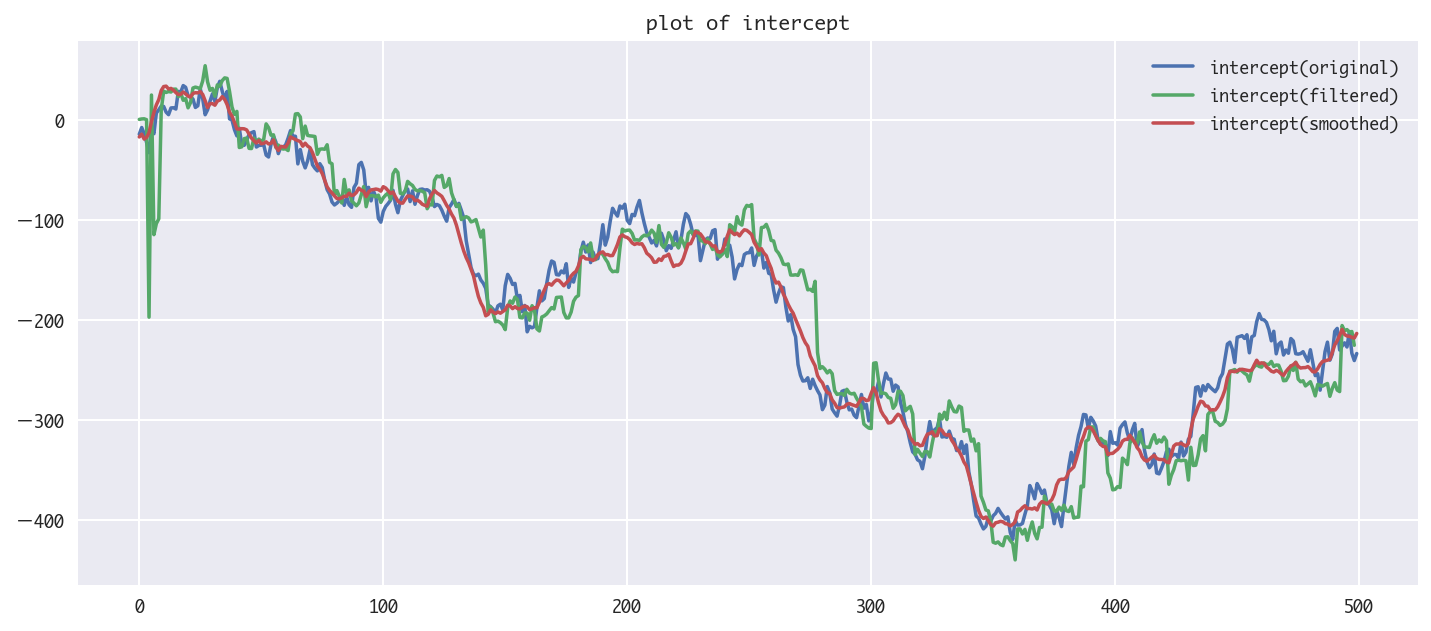

In [170]:

plt.figure(figsize=(12,5))
plt.plot(df.intercept, label="intercept(original)")
plt.plot(filtered_a[omit_first_filters:,0], label="intercept(filtered)")
plt.plot(smoothed_a[1:,0], label="intercept(smoothed)")
plt.legend(loc="best")
plt.title("plot of intercept")

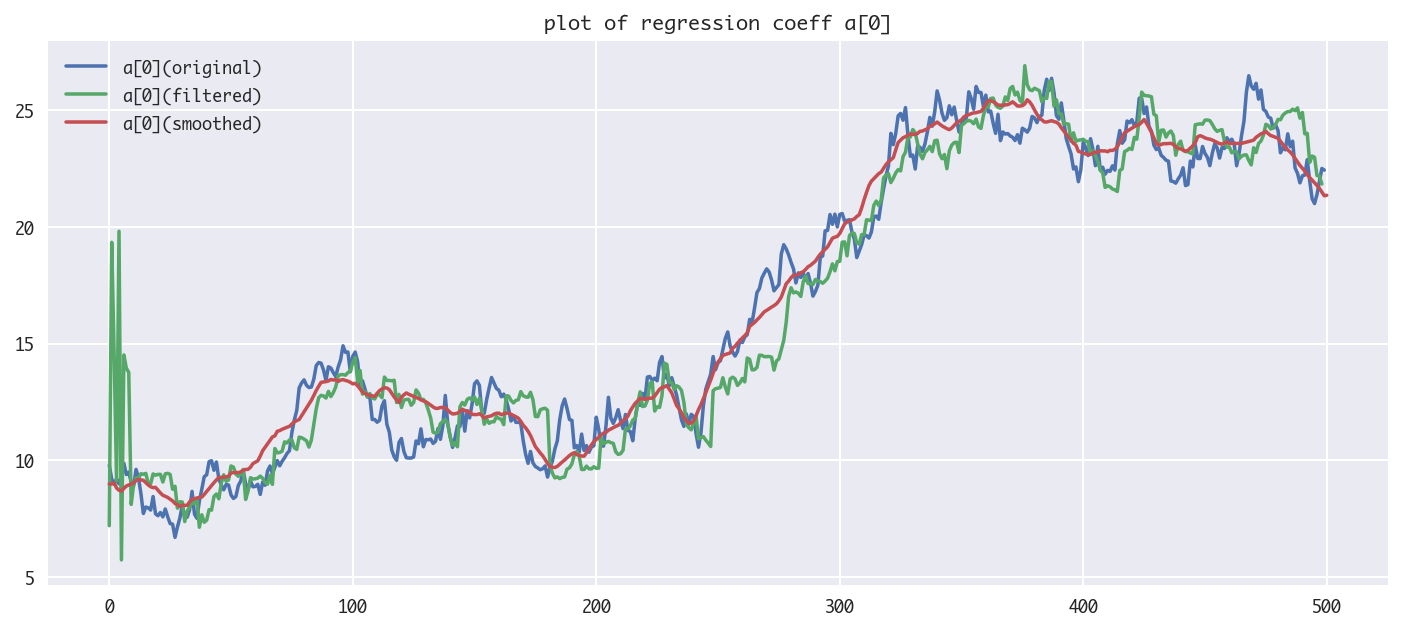

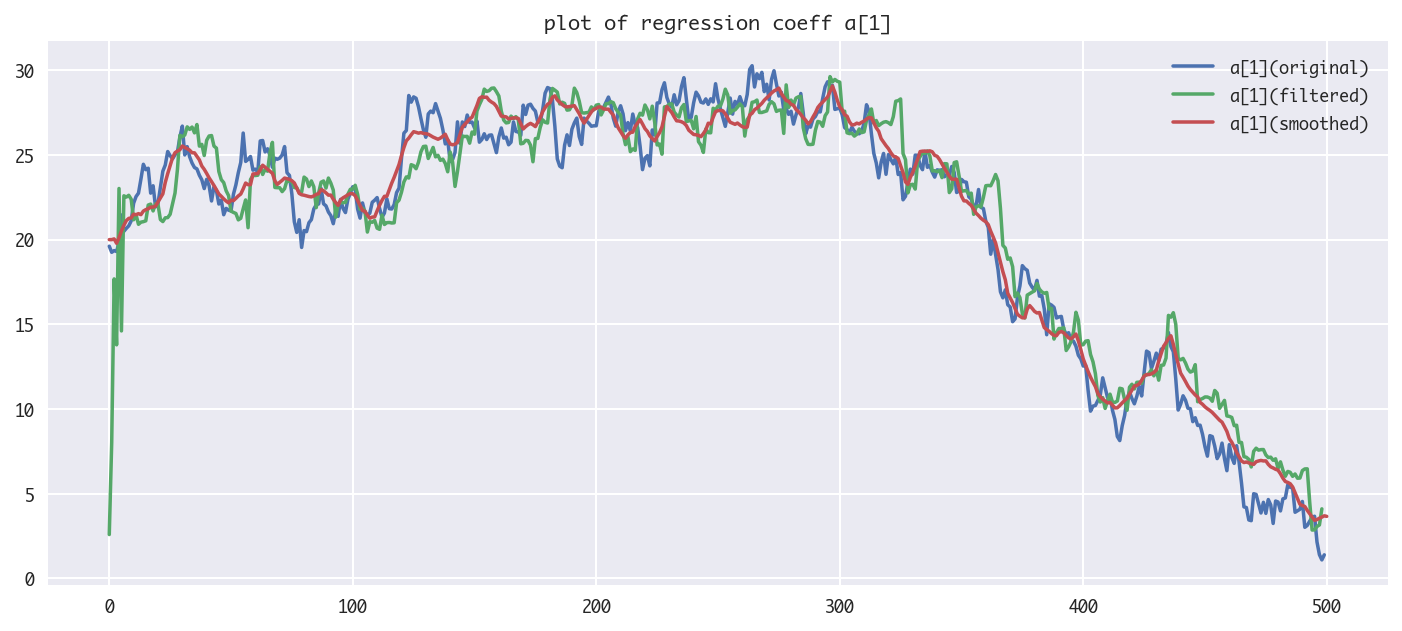

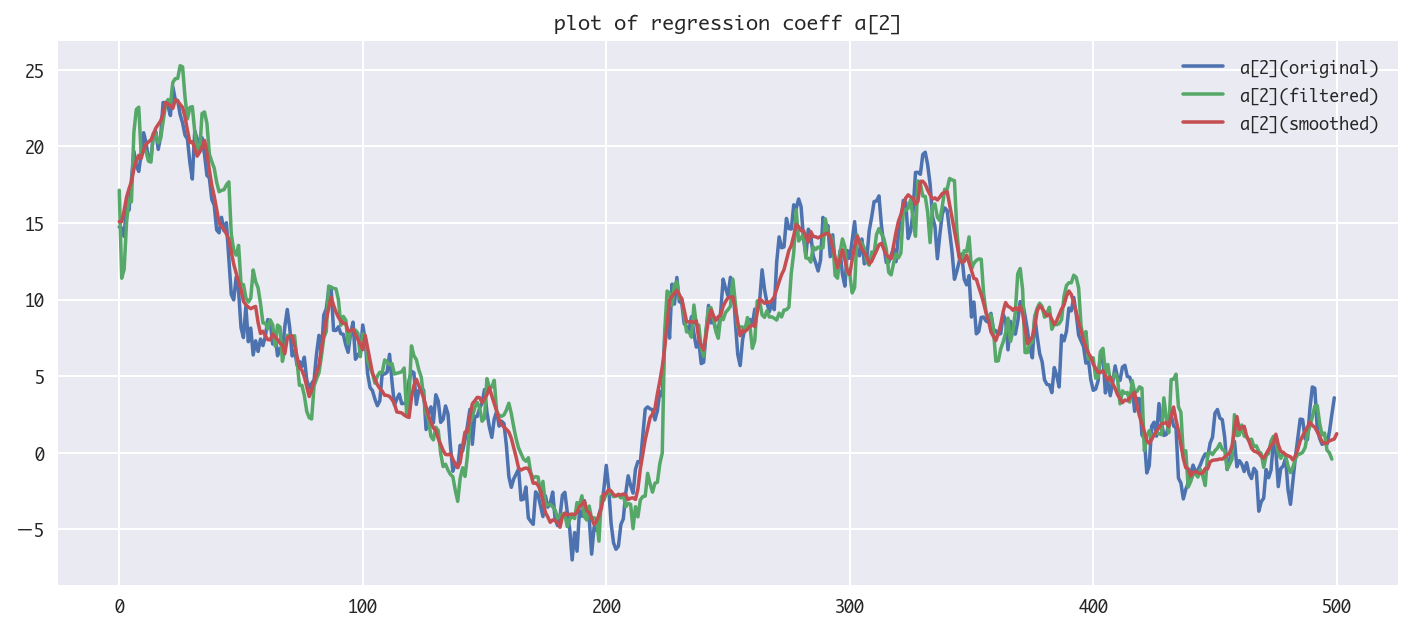

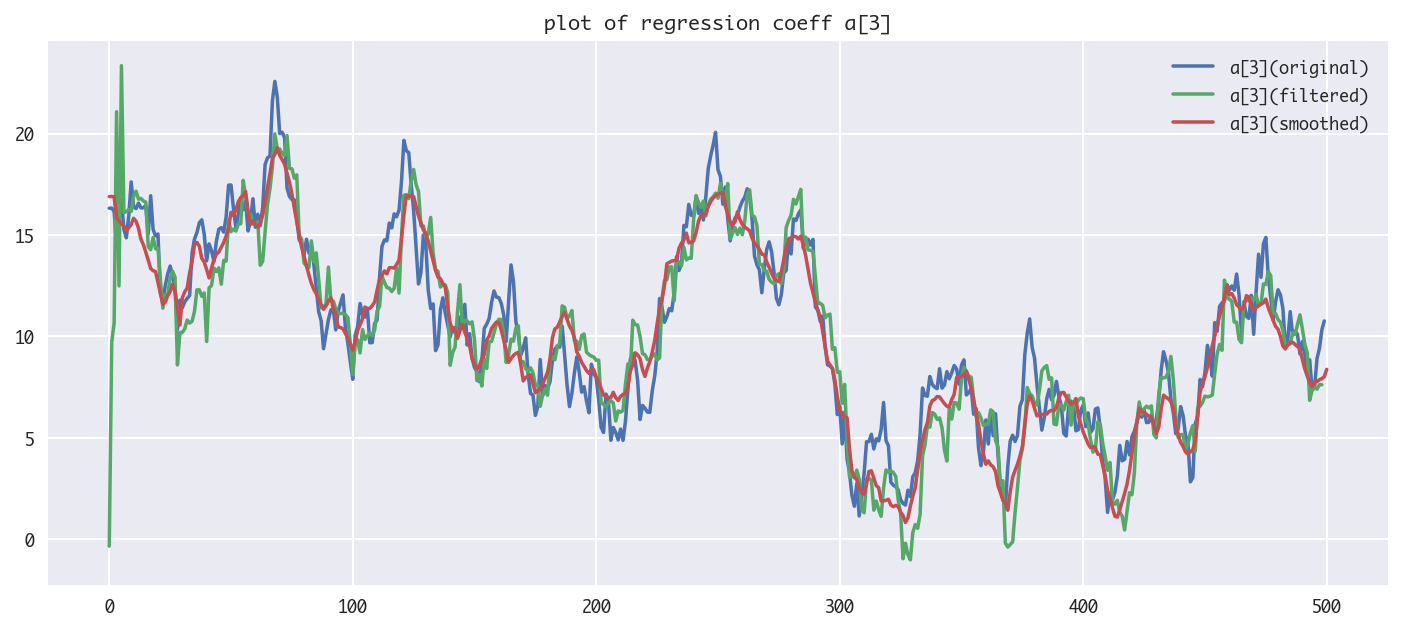

In [171]:
for i in range(len(a_dict)):
    plt.figure(figsize=(12,5))
    plt.plot(df["a{}".format(i)], label="a[{}](original)".format(i))
    plt.plot(filtered_a[omit_first_filters:,i+1], label="a[{}](filtered)".format(i))
    plt.plot(smoothed_a[:,i+1], label="a[{}](smoothed)".format(i))
    plt.legend(loc="best")
    plt.title("plot of regression coeff a[{}]".format(i))

In [172]:
estimatedLevel = smoothed_a[1:,0] + np.diag(np.dot(df_x, smoothed_a[1:, 1:].T))

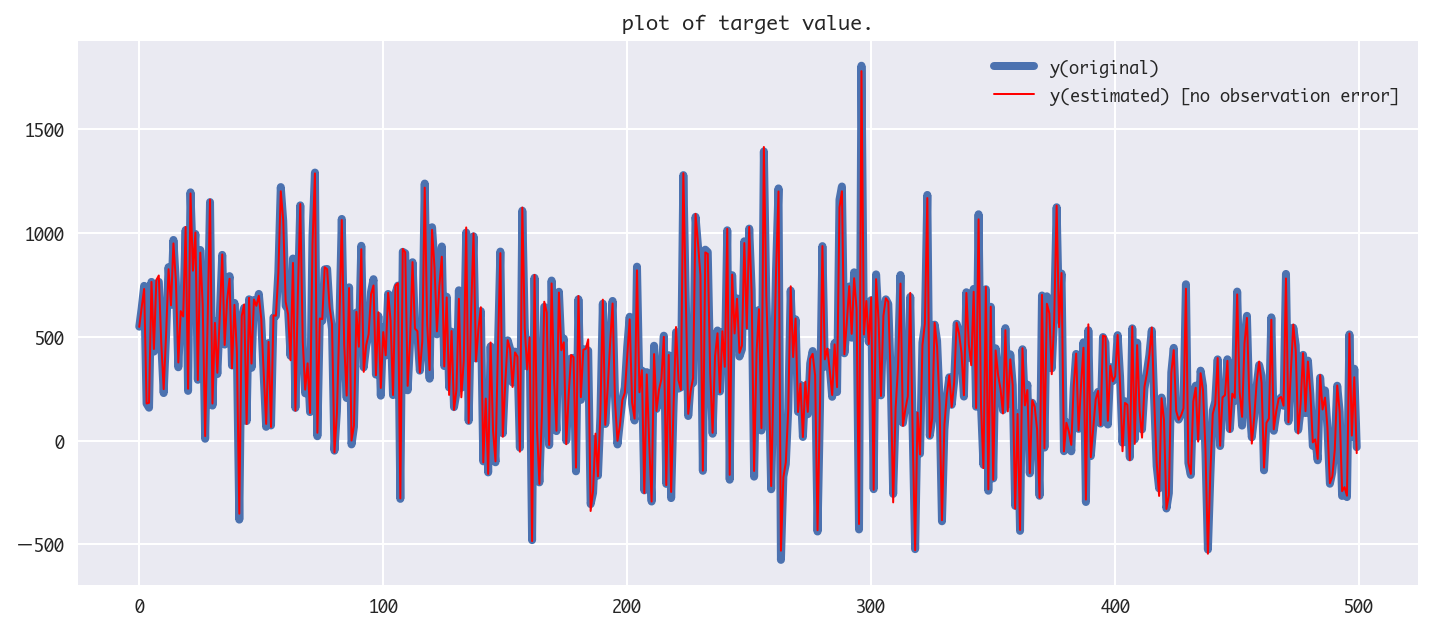

In [173]:
plt.figure(figsize=(12,5))
plt.plot(y_noerror, lw=4, label="y(original)")
plt.plot(estimatedLevel, "r", lw=1, label="y(estimated) [no observation error]")
plt.legend(loc="best")
plt.title("plot of target value.")